In [1]:
from utils import cp_detector as cpd
from utils import data_generation as gen
from utils import statistic_calculation as stat
from utils import threshold_calculation as th

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# lin_stat_alpha = {}
# lin_stat_alpha_ln = {}
# lin_stat_beta = {}
# lin_stat_beta_ln = {}

# dataset_parameters = {
#     "dataset_size": 500,
#     "seq_len": 101,
#     "d": 10,
#     "p": 5,
#     "distribution": "t-distribution",
#     "k": 10,
#     "cp": None,
#     "nu": 10
# }

# cp_parameters = {
#     "alpha": 0.05,
#     "scan": False,
#     "data_based": False,
#     "ln": False
# }

# for d in range(10, 1000, 50):
#     print(d)
#     dataset_parameters["d"] = d
#     (fn, fp), (fn_ln, яfp_ln) = cpd.cpd_with_ln_compare(
#         dataset_parameters, cp_parameters, data_type="t-distribution"
#     )
#     lin_stat_alpha[d] = fp
#     lin_stat_alpha_ln[d] = fp_ln
#     lin_stat_beta[d] = fn
#     lin_stat_beta_ln[d] = fn_ln

In [104]:
import pickle
path = "outputs/2024-02-21/15-06-57/"

with open(path + 'alpha.pickle', 'rb') as f:
    lin_stat_alpha = pickle.load(f)
with open(path + 'beta.pickle', 'rb') as f:
    lin_stat_beta = pickle.load(f)
with open(path + 'alpha_ln.pickle', 'rb') as f:
    lin_stat_alpha_ln = pickle.load(f)
with open(path + 'beta_ln.pickle', 'rb') as f:
    lin_stat_beta_ln = pickle.load(f)

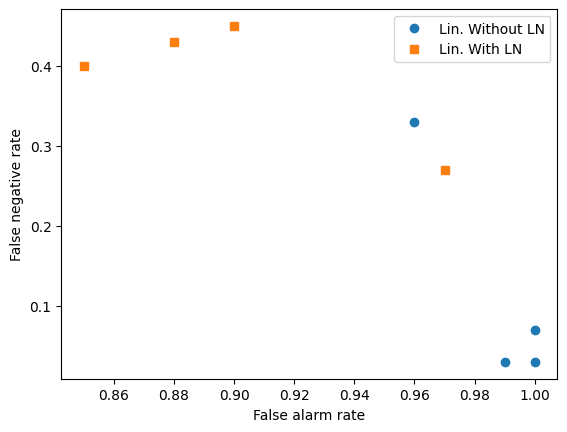

In [105]:
plt.plot(
    [value for value in lin_stat_alpha.values()],
    [value for value in lin_stat_beta.values()],
    "o",
    label="Lin. Without LN",
)

plt.plot(
    [value for value in lin_stat_alpha_ln.values()],
    [value for value in lin_stat_beta_ln.values()],
    "s",
    label="Lin. With LN",
)

plt.xlabel("False alarm rate")
plt.ylabel("False negative rate")
plt.legend()

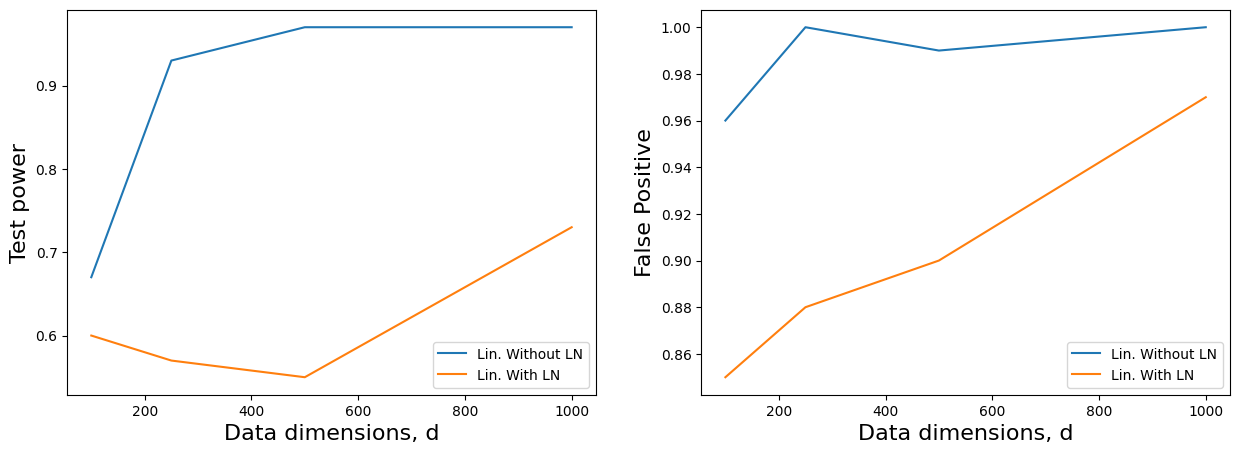

In [106]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(
    [key for key in lin_stat_beta.keys()],
    [1 - value for value in lin_stat_beta.values()],
    label="Lin. Without LN",
)

ax1.plot(
    [key for key in lin_stat_beta_ln.keys()],
    [1 - value for value in lin_stat_beta_ln.values()],
    label="Lin. With LN",
)

ax1.set_xlabel("Data dimensions, d", fontsize=16)
ax1.set_ylabel("Test power", fontsize=16)
ax1.legend()

ax2.plot(
    [key for key in lin_stat_beta.keys()],
    [value for value in lin_stat_alpha.values()],
    label="Lin. Without LN",
)

ax2.plot(
    [key for key in lin_stat_beta_ln.keys()],
    [value for value in lin_stat_alpha_ln.values()],
    label="Lin. With LN",
)

ax2.set_xlabel("Data dimensions, d", fontsize=16)
ax2.set_ylabel("False Positive", fontsize=16)
plt.legend()

In [49]:
chi2.ppf(1 - 0.05 / 100, 10) 

31.41981250740049

In [100]:
dataset_parameters = {
    "dataset_size": 500,
    "seq_len": 101,
    "d": 250,
    "p": 5,
    "distribution": "t-distribution",
    "k": 1,
    "cp": None,
    "nu": 3
}

cp_parameters = {
    "alpha": 0.05,
    "ln": False,
    "scan": False,
    "data_based": True,
}

In [3]:
dataset_parameters["k"] = 1
t_data_with_cp, t_data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)
t_predicted_cp_1, delta_sic_1 = cpd.detect_cps_t_dist(t_data_with_cp, dataset_parameters, cp_parameters["alpha"])
# norm_predicted_cp, l_statistic = cpd.detect_cps_normal(t_data_with_cp, dataset_parameters, **cp_parameters)

In [4]:
dataset_parameters["k"] = 3
t_data_with_cp, t_data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)
t_predicted_cp_3, delta_sic_3 = cpd.detect_cps_t_dist(t_data_with_cp, dataset_parameters, cp_parameters["alpha"])

In [5]:
dataset_parameters["k"] = 5
t_data_with_cp, t_data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)
t_predicted_cp_5, delta_sic_5 = cpd.detect_cps_t_dist(t_data_with_cp, dataset_parameters, cp_parameters["alpha"])

In [6]:
dataset_parameters["k"] = 10
t_data_with_cp, t_data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)
t_predicted_cp_10, delta_sic_10 = cpd.detect_cps_t_dist(t_data_with_cp, dataset_parameters, cp_parameters["alpha"])

Text(0.5, 1.0, 'k = 10')

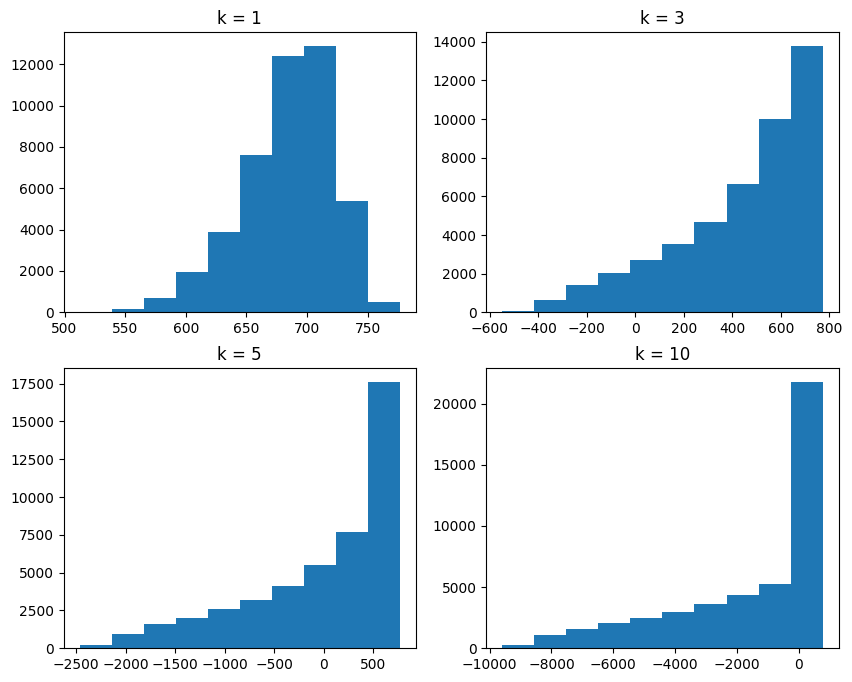

In [83]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(delta_sic_1[:, 5:-5].flatten());
axs[0, 0].set_title('k = 1')


axs[0, 1].hist(delta_sic_3[:, 5:-5].flatten());
axs[0, 1].set_title('k = 3')

axs[1, 0].hist(delta_sic_5[:, 5:-5].flatten());
axs[1, 0].set_title('k = 5')


axs[1, 1].hist(delta_sic_10[:, 5:-5].flatten());
axs[1, 1].set_title('k = 10')


Text(0.5, 1.0, 'k = 10')

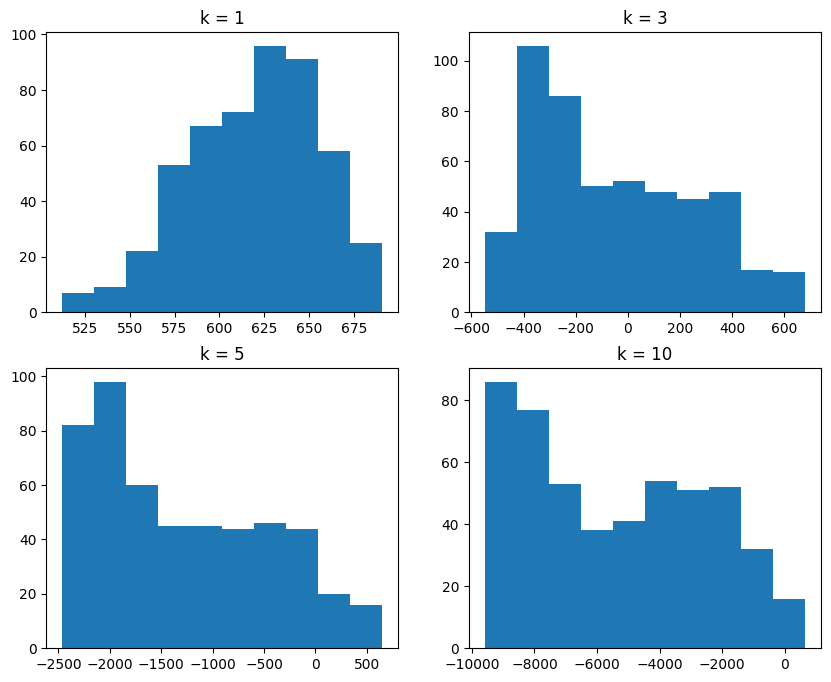

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(delta_sic_1.min(1).flatten());
axs[0, 0].set_title('k = 1')


axs[0, 1].hist(delta_sic_3.min(1).flatten());
axs[0, 1].set_title('k = 3')

axs[1, 0].hist(delta_sic_5.min(1).flatten());
axs[1, 0].set_title('k = 5')


axs[1, 1].hist(delta_sic_10.min(1).flatten());
axs[1, 1].set_title('k = 10')


In [67]:
import pandas as pd

def before_after_cp(delta_sic, cp_idxs, w=5):
    before_cp = []
    after_cp = []
    seq_len = delta_sic.shape[1]
    for i in range(len(delta_sic)):
        if cp_idxs[i] > seq_len - w:
            cp = seq_len - w
        else:
            cp = cp_idxs[i]
        before_cp.append(delta_sic[i, w:cp])
        after_cp.append(delta_sic[i, cp_idxs[i]:-w])
    before_cp = np.hstack(before_cp)
    after_cp = np.hstack(after_cp)
    return before_cp, after_cp

In [70]:
before_1, after_1 = before_after_cp(delta_sic_1, t_cp_idxs)
before_5, after_5 = before_after_cp(delta_sic_5, t_cp_idxs)

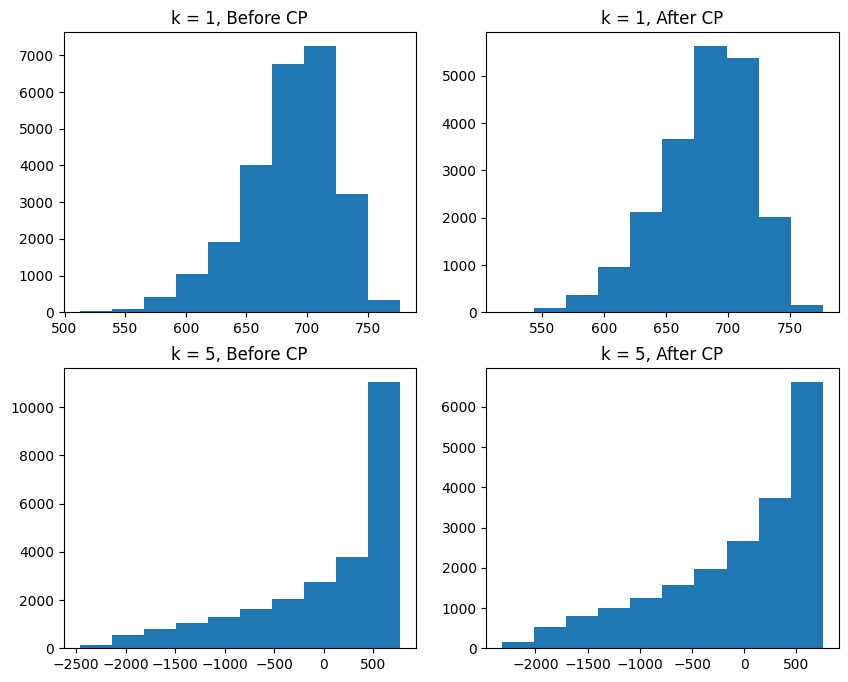

In [81]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(before_1);
axs[0, 0].set_title('k = 1, Before CP')


axs[0, 1].hist(after_1);
axs[0, 1].set_title('k = 1, After CP')

axs[1, 0].hist(before_5);
axs[1, 0].set_title('k = 5, Before CP')


axs[1, 1].hist(after_5);
axs[1, 1].set_title('k = 5, After CP');


In [73]:
dataset_parameters["k"] = 1
t_data_with_cp, t_data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)
_, delta_sic_1 = cpd.detect_cps_t_dist(t_data_with_cp, dataset_parameters, cp_parameters["alpha"])
_, delta_sic_without_1 = cpd.detect_cps_t_dist(t_data_without_cp, dataset_parameters, cp_parameters["alpha"])

dataset_parameters["k"] = 3
t_data_with_cp, t_data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)
_, delta_sic_3 = cpd.detect_cps_t_dist(t_data_with_cp, dataset_parameters, cp_parameters["alpha"])
_, delta_sic_without_3 = cpd.detect_cps_t_dist(t_data_without_cp, dataset_parameters, cp_parameters["alpha"])

dataset_parameters["k"] = 5
t_data_with_cp, t_data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)
_, delta_sic_5 = cpd.detect_cps_t_dist(t_data_with_cp, dataset_parameters, cp_parameters["alpha"])
_, delta_sic_without_5 = cpd.detect_cps_t_dist(t_data_without_cp, dataset_parameters, cp_parameters["alpha"])

dataset_parameters["k"] = 10
t_data_with_cp, t_data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)
_, delta_sic_10 = cpd.detect_cps_t_dist(t_data_with_cp, dataset_parameters, cp_parameters["alpha"])
_, delta_sic_without_10 = cpd.detect_cps_t_dist(t_data_without_cp, dataset_parameters, cp_parameters["alpha"])

Text(0.5, 1.0, 'k = 10')

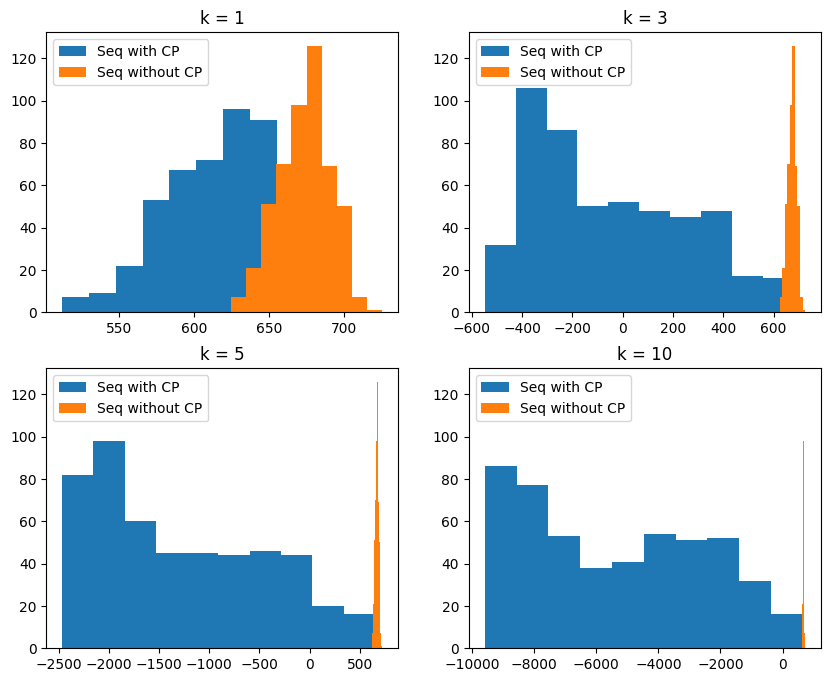

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(delta_sic_1.min(1).flatten(), label='Seq with CP');
axs[0, 0].hist(delta_sic_without_1.min(1).flatten(), label='Seq without CP');
axs[0, 0].legend();
axs[0, 0].set_title('k = 1');


axs[0, 1].hist(delta_sic_3.min(1).flatten(), label='Seq with CP');
axs[0, 1].hist(delta_sic_without_3.min(1).flatten(), label='Seq without CP');
axs[0, 1].legend();
axs[0, 1].set_title('k = 3')

axs[1, 0].hist(delta_sic_5.min(1).flatten(), label='Seq with CP');
axs[1, 0].hist(delta_sic_without_5.min(1).flatten(), label='Seq without CP');
axs[1, 0].legend();
axs[1, 0].set_title('k = 5')


axs[1, 1].hist(delta_sic_10.min(1).flatten(), label='Seq with CP');
axs[1, 1].hist(delta_sic_without_10.min(1).flatten(), label='Seq without CP');
axs[1, 1].legend();
axs[1, 1].set_title('k = 10')


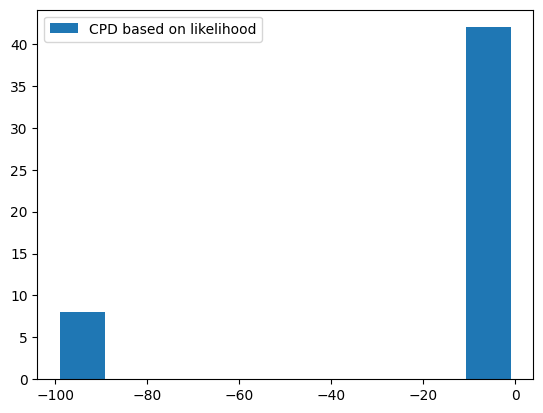

In [45]:
# plt.hist(np.where(t_predicted_cp==-1, -99, t_predicted_cp - t_cp_idxs), label="CPD based on likelihood");
# plt.hist(np.where(norm_predicted_cp==-1, -99, t_predicted_cp - t_cp_idxs), alpha=0.6, label="CPD based on L2 norm");
# plt.legend();

In [9]:
dataset_parameters = {
    "dataset_size": 500,
    "seq_len": 101,
    "d": 400,
    "p": 5,
    "distribution": "t-distribution",
    "k": 1,
    "cp": None,
    "nu": 10
}

cp_parameters = {
    "alpha": 0.05,
    "ln": False,
    "scan": False,
    "data_based": True,
}

In [10]:
dataset_parameters["k"] = 1
t_data_with_cp, t_data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)
_, delta_sic_1 = cpd.detect_cps_t_dist(t_data_with_cp, dataset_parameters, cp_parameters["alpha"])
_, delta_sic_without_1 = cpd.detect_cps_t_dist(t_data_without_cp, dataset_parameters, cp_parameters["alpha"])


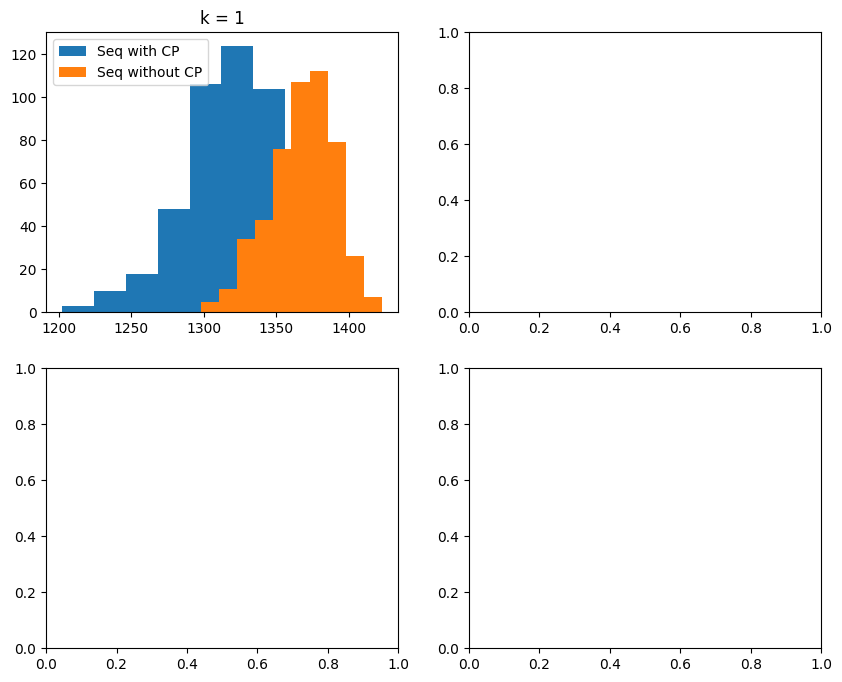

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(delta_sic_1.min(1).flatten(), label='Seq with CP');
axs[0, 0].hist(delta_sic_without_1.min(1).flatten(), label='Seq without CP');
axs[0, 0].legend();
axs[0, 0].set_title('k = 1');
